In [122]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [123]:
import pandas as pd
import numpy as np

from src import models
from src import experimental_setup
experimental_setup.path_prefix = '/../'

# Experimental setup

In [137]:
_benchmarks = {
    'dnn_mordred': {'model': models.DNN_Mordred, 'encoding': 'mordred'},
    'dnn_ecfp': {'model': models.DNN_ECFP, 'encoding': 'ecfp_2048'},
    'rf_mordred': {'model': models.RF, 'encoding': 'mordred'},
    'rf_ecfp': {'model': models.RF, 'encoding': 'ecfp_4096'},
    'rf_nmf_ecfp': {'model': models.RF_NMF_ECFP, 'encoding': 'ecfp_4096'},
    'gp': {'model': models.GP, 'encoding': 'gp'},
    'gcn': {'model': models.GCN, 'encoding': 'smiles'}
}

# benchmarks to train/validate, check _benchmark_dict for options
run_benchmarks = ['dnn_mordred','dnn_ecfp']

# `random` or `stratified`
sampling_type = 'random'

kfold = experimental_setup.CrossValidator(
    splits = 3, # dont change without re-running data preprocessing
    sampling_type = sampling_type,
)

converter = experimental_setup.LD50UnitConverter()

# Train/predict using benchmark models

In [138]:
loss_histories = {}
for identity in run_benchmarks:
    benchmark = _benchmarks[identity]
    
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, (train, test) in folds:           
        x_train, y_train, smiles_train = train
        x_test, y_test, smiles_test = test
        
        y_train = experimental_setup.scaler.fit_transform(y_train)
        
        model = _benchmarks[identity]['model']()
        
        # <Gaussian process has special step for selecting parameters based on
        # RF benchmark models for ECFP and Mordred
        if identity == 'gp':
            fn = 'rf_mordred' + str(fold_no) + '_' + sampling_type
            mordred_rf = _benchmarks['rf_mordred']['model']()
            mordred_rf.load_weights('../../data/benchmark-models/chkpts/%s.chkpt' % fn)
            
            fn = 'rf_ecfp' + str(fold_no) + '_' + sampling_type
            ecfp_rf = _benchmarks['rf_ecfp']['model']()
            ecfp_rf.load_weights('../../data/benchmark-models/chkpts/%s.chkpt' % fn)
            
            model.rf_feature_selectors = (mordred_rf, ecfp_rf)
            model.rf_feature_reduce_to = (10, 200)
        # End of special GP step>
        
        #Mordred and ECPF Loss: 
        # Mordred and ECFP Loss collection
        if identity == 'dnn_mordred':
            DNN_mordredLosses = model.fit(x_train, y_train)
            loss_histories.setdefault('dnn_mordred', []).append(DNN_mordredLosses)
        
        if identity == 'dnn_ecfp':     
            DNN_ecfpLosses = model.fit(x_train, y_train)
            loss_histories.setdefault('dnn_ecfp', []).append(DNN_ecfpLosses)


        
        #save model
        fn = identity + str(fold_no) + '_' + sampling_type
        model.save_weights('../../data/benchmark-models/chkpts/%s.chkpt' % fn)
        
        y_hat = experimental_setup.scaler.inverse_transform(model.predict(x_test)) 
        
        results = pd.DataFrame({
            'smiles': smiles_test.flatten(),
            'prediction_neglogld50': y_hat.flatten(),
            'prediction_mgkg': converter.convert_to_mgkg(y_hat, smiles_test),
            'prediction_epa': converter.convert_to_epa(y_hat, smiles_test),
            'actual_neglogld50': y_test.flatten(),
            'actual_mgkg': converter.convert_to_mgkg(y_test, smiles_test),
            'actual_epa': converter.convert_to_epa(y_test, smiles_test),
        })
        
        results.to_csv('../../data/benchmark-models/%s_predictions.csv' % fn)

Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn__mordred_56', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 652848.5000 - mae: 216.5025 - mse: 652848.5000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8871 - mae: 0.9941 - mse: 1.8871
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0590 - mae: 0.7750 - mse: 1.0590
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0039 - mae: 0.7607 - mse: 1.0039
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0037 - mae: 0.7617 - mse: 1.0037
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9699 - mae: 0.7533 - mse: 0.9699
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9512 - mae: 0.7418 - mse: 0.9512
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9786 - mae: 0.7444 - mse: 0.9786
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0601 - mae: 0.7663 - mse: 1.0601
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1198 - mae: 0.7817 - mse: 1.1198
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn__mordred_57', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 679896.5625 - mae: 211.5028 - mse: 679896.5625
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0727 - mae: 1.3909 - mse: 4.0727
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2083 - mae: 0.8692 - mse: 1.2083
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1145 - mae: 0.8318 - mse: 1.1145
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0447 - mae: 0.8027 - mse: 1.0447
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0457 - mae: 0.8021 - mse: 1.0457
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0277 - mae: 0.7947 - mse: 1.0277
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9869 - mae: 0.7776 - mse: 0.9869
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9428 - mae: 0.7590 - mse: 0.9428
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9079 - mae: 0.7402 - mse: 0.9079
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn__mordred_58', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1345739.1250 - mae: 262.7687 - mse: 1345739.1250
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9806 - mae: 1.5163 - mse: 4.9806
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2030 - mae: 0.8515 - mse: 1.2030
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1224 - mae: 0.8251 - mse: 1.1224
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0395 - mae: 0.7915 - mse: 1.0395
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0102 - mae: 0.7795 - mse: 1.0102
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9867 - mae: 0.7681 - mse: 0.9867
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9568 - mae: 0.7536 - mse: 0.9568
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9693 - mae: 0.7573 - mse: 0.9693
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0317 - mae: 0.7782 - mse: 1.0317
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn_ecfp_55', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.7286 - mae: 0.6378 - mse: 0.7286
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.3690 - mae: 0.4473 - mse: 0.3690
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.2710 - mae: 0.3807 - mse: 0.2710
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.1978 - mae: 0.3192 - mse: 0.1978
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.1497 - mae: 0.2748 - mse: 0.1497
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.1414 - mae: 0.2806 - mse: 0.1414
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.1145 - mae: 0.2487 - mse: 0.1145
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.1005 - mae: 0.2346 - mse: 0.1005
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.1062 - mae: 0.2472 - mse: 0.1062
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.1387 - mae: 0.2953 - mse: 0.1387
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn_ecfp_56', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.7660 - mae: 0.6647 - mse: 0.7660
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.3720 - mae: 0.4544 - mse: 0.3720
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.2739 - mae: 0.3836 - mse: 0.2739
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.1999 - mae: 0.3217 - mse: 0.1999
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.1459 - mae: 0.2683 - mse: 0.1459
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.1078 - mae: 0.2244 - mse: 0.1078
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0829 - mae: 0.1934 - mse: 0.0829
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0718 - mae: 0.1831 - mse: 0.0718
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0804 - mae: 0.2020 - mse: 0.0804
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.1206 - mae: 0.2709 - mse: 0.1206
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1/10


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dnn_ecfp_57', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.7518 - mae: 0.6557 - mse: 0.7518
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.3839 - mae: 0.4600 - mse: 0.3839
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.3008 - mae: 0.4075 - mse: 0.3008
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.2133 - mae: 0.3346 - mse: 0.2133
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.1584 - mae: 0.2821 - mse: 0.1584
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.1186 - mae: 0.2393 - mse: 0.1186
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0937 - mae: 0.2094 - mse: 0.0937
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0838 - mae: 0.2027 - mse: 0.0838
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0965 - mae: 0.2316 - mse: 0.0965
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.2153 - mae: 0.3724 - mse: 0.2153
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [136]:
import matplotlib.pyplot as plt

# Plotting the losses for each model
plt.figure(figsize=(12, 8))

# Plot losses for DNN_Mordred
if 'dnn_mordred' in loss_histories:
    for fold_no, history_df in enumerate(loss_histories['dnn_mordred']):
        plt.plot(history_df['epoch'], history_df['loss'], label=f'DNN_Mordred Fold {fold_no+1} Loss')

# Plot losses for DNN_ECFP
if 'dnn_ecfp' in loss_histories:
    for fold_no, history_df in enumerate(loss_histories['dnn_ecfp']):
        plt.plot(history_df['epoch'], history_df['loss'], label=f'DNN_ECFP Fold {fold_no+1} Loss')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for DNN_Mordred and DNN_ECFP')
plt.legend()
plt.show()

TypeError: 'NoneType' object is not subscriptable

<Figure size 1200x800 with 0 Axes>

# Results comparison

In [128]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

compare_benchmarks = ['dnn_mordred','dnn_ecfp'] #,'gp','gcn'] 
#compare_benchmarks = ['rf_mordred','rf_ecfp','rf_nmf_ecfp','dnn_mordred','dnn_ecfp','gp','gcn'] 

aggregated = pd.DataFrame()
    
for identity in compare_benchmarks:
    benchmark = _benchmarks[identity]
    
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, data in folds:
        fn = identity + str(fold_no) + '_' + sampling_type
        
        validation = pd.read_csv('../../data/benchmark-models/%s_predictions.csv' % fn)
        
        '''aggregated = aggregated.append({
            'benchmark': identity,
            'r2': r2_score(validation['actual_neglogld50'], validation['prediction_neglogld50']),
            'mae': mean_absolute_error(validation['actual_neglogld50'], validation['prediction_neglogld50']),
            'rmse': mean_squared_error(validation['actual_neglogld50'], validation['prediction_neglogld50'], squared=False),
            'accuracy': np.sum(validation['actual_epa'] == validation['prediction_epa']) / len(validation)
        }, ignore_index=True) '''


        #   Create a temporary DataFrame for each result
        temp_df = pd.DataFrame({
            'benchmark': [identity],
            'r2': [r2_score(validation['actual_neglogld50'], validation['prediction_neglogld50'])],
            'mae': [mean_absolute_error(validation['actual_neglogld50'], validation['prediction_neglogld50'])],
            'rmse': [mean_squared_error(validation['actual_neglogld50'], validation['prediction_neglogld50'], squared=False)],
            'accuracy': [np.sum(validation['actual_epa'] == validation['prediction_epa']) / len(validation)],
            'variance': [np.var(validation['actual_neglogld50'], ddof=1)],  # ddof=1 for sample variance
            'prediction-variance': [np.var(validation['prediction_neglogld50'], ddof=1)],  # ddof=1 for sample variance
            #'Coef-Of Variance-Actual': np.std(validation['actual_neglogld50']) / np.mean(validation['actual_neglogld50']),
            #'Coef-Of Variance-Predicted': np.std(validation['prediction_neglogld50']) / np.mean(validation['prediction_neglogld50'])

        })
        
        # Use pd.concat() to append the temp_df to the aggregated DataFrame
        aggregated = pd.concat([aggregated, temp_df], ignore_index=True)

# The DataFrame 'aggregated' now contains the results from all benchmarks.

c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

In [130]:
aggregated.pivot_table(index='benchmark', aggfunc=np.mean)

C:\Users\3742\AppData\Local\Temp\ipykernel_11556\3530873064.py:1: FutureWarning: The provided callable <function mean at 0x00000228BD7B6E80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  aggregated.pivot_table(index='benchmark', aggfunc=np.mean)


,accuracy,mae,prediction-variance,r2,rmse,variance
benchmark,,,,,,
dnn_ecfp,0.619850,0.406419,0.565688,0.605818,0.553027,0.777076
dnn_mordred,0.408439,1.357137,2.385068,-6.928381,1.778698,0.777076


In [ ]:
#Results Using 5 Folds.
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


output_file = 'ConsolRes.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for identity in compare_benchmarks:
        actual = benchmark_results[identity]['actual']
        predicted = benchmark_results[identity]['predicted']
        
        
        unique_classes = np.sort(np.unique(np.concatenate((actual, predicted))))  # Ensure consistent class order
        cm = confusion_matrix(actual, predicted, labels=unique_classes)

        cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)
        # Add row totals
        cm_df['Row Totals'] = cm_df.sum(axis=1)

        # Add column totals
        cm_df.loc['Column Totals'] = cm_df.sum(axis=0)

        
        # Write the confusion matrix with totals to a specified sheet in the Excel file
        sheet_name = f'{identity}x_train-y-train_Confusion_Matrix'
        cm_df.to_excel(writer, sheet_name=sheet_name)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, cbar_kws={'shrink': 0.8}, 
                    xticklabels=unique_classes, yticklabels=unique_classes)
        #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=unique_classes, yticklabels=unique_classes)
        plt.title(f'Confusion Matrix for {identity} using {fold_no +1} folds')
        plt.xlabel('Predicted EPA Class')
        plt.ylabel('Actual EPA Class')
        plt.show()


# Placeholder for results
    results = []

    for identity in compare_benchmarks:
        actual = benchmark_results[identity]['actual']
        predicted = benchmark_results[identity]['predicted']
        
        unique_classes = np.sort(np.unique(np.concatenate((actual, predicted))))  # Ensure consistent class order
        cm = confusion_matrix(actual, predicted, labels=unique_classes)
        
        # Calculate precision, recall, and F1 score for each class
        precision = precision_score(actual, predicted, labels=unique_classes, average=None)
        recall = recall_score(actual, predicted, labels=unique_classes, average=None)
        f1 = f1_score(actual, predicted, labels=unique_classes, average=None)
        
        # Add each metric to the results table
        for idx, class_label in enumerate(unique_classes):
            results.append({
                'Identity': identity,
                'EPA Class': class_label,
                'Precision': precision[idx],
                'Recall': recall[idx],
                'F1 Score': f1[idx]
                })

    # Convert results to a DataFrame for easy display
    results_df = pd.DataFrame(results)

    # Display the table
    print(f'F1 Score of Kfolds = {fold_no +1} is: \n{results_df}')

    # Save to Excel if needed
    #output_file = 'F1ScoresOnMatrices_Results.xlsx'
    sheet_name = f'{identity}F1 scores '
    results_df.to_excel(writer, sheet_name = sheet_name) #output_file, index=False)

    sheet_name = f'Ers&Accs{fold_no+1}'
    aggregated_df = aggregated.pivot_table(index='benchmark', aggfunc=np.mean)
    aggregated_df.to_excel(writer, sheet_name = sheet_name)
 



'''import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

output_file = 'ConsolRes.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for identity in compare_benchmarks:
        actual = benchmark_results[identity]['actual']
        predicted = benchmark_results[identity]['predicted']
        
        # Ensure consistent class order
        unique_classes = np.sort(np.unique(np.concatenate((actual, predicted))))
        cm = confusion_matrix(actual, predicted, labels=unique_classes)

        # Convert confusion matrix to DataFrame
        cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)
        cm_df['Row Totals'] = cm_df.sum(axis=1)  # Add row totals
        cm_df.loc['Column Totals'] = cm_df.sum(axis=0)  # Add column totals

        # Write confusion matrix to Excel
        sheet_name = f'{identity}x_train-y-train_Confusion_Matrix'
        cm_df.to_excel(writer, sheet_name=sheet_name)

        # Plot the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df.iloc[:-1, :-1], annot=True, fmt='d', cmap='Blues', cbar=True, 
                    xticklabels=unique_classes, yticklabels=unique_classes)
        plt.title(f'Confusion Matrix for {identity} using {fold_no + 1} folds')
        plt.xlabel('Predicted EPA Class')
        plt.ylabel('Actual EPA Class')
        plt.show()

    ### Calculating the F1 Scores and the prediction scores
    results = []
    for identity in compare_benchmarks:
        actual = benchmark_results[identity]['actual']
        predicted = benchmark_results[identity]['predicted']
        
        # Calculate precision, recall, and F1 score for each class
        precision = precision_score(actual, predicted, labels=unique_classes, average=None)
        recall = recall_score(actual, predicted, labels=unique_classes, average=None)
        f1 = f1_score(actual, predicted, labels=unique_classes, average=None)
        
        # Add each metric to the results table
        for idx, class_label in enumerate(unique_classes):
            results.append({
                'Identity': identity,
                'EPA Class': class_label,
                'Precision': precision[idx],
                'Recall': recall[idx],
                'F1 Score': f1[idx]
            })

    # Convert results to a DataFrame for easy display
    results_df = pd.DataFrame(results)

    # Print the F1 scores for the current fold
    print(f'F1 Score of Kfolds = {fold_no + 1} is:\n{results_df}')

    # Write F1 scores to Excel
    sheet_name = f'{identity}F1_scores'
    results_df.to_excel(writer, sheet_name=sheet_name)

    # Create and write the pivot table of aggregated metrics to Excel
    sheet_name = f'Ers&Accs{fold_no+1}'
    aggregated_df = aggregated.pivot_table(index='benchmark', aggfunc=np.mean)
    aggregated_df.to_excel(writer, sheet_name=sheet_name)

print("Results have been successfully saved to", output_file)
'''


In [140]:
print(fold_no)


2


c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


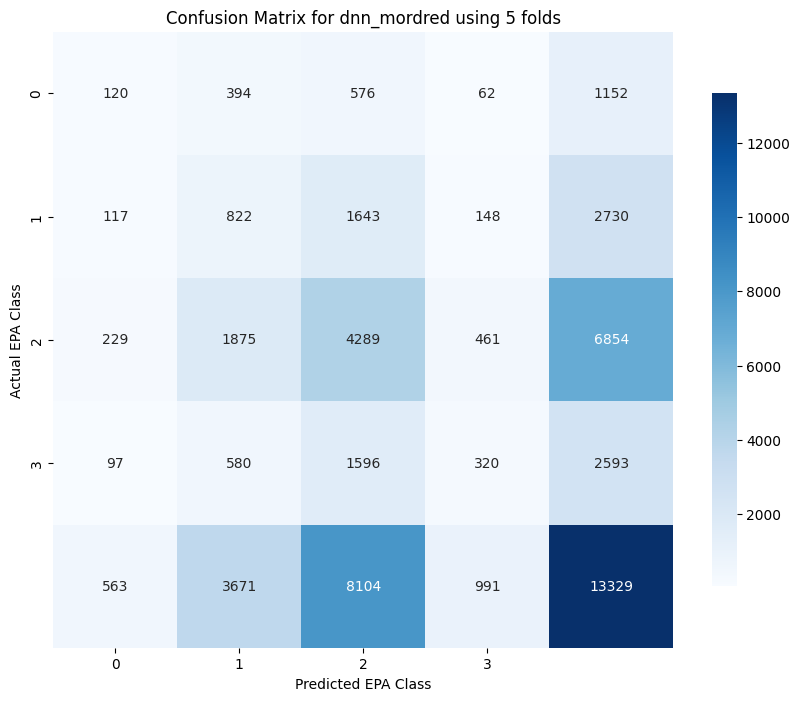

c:\Users\3742\anaconda3\envs\ai4pfas\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


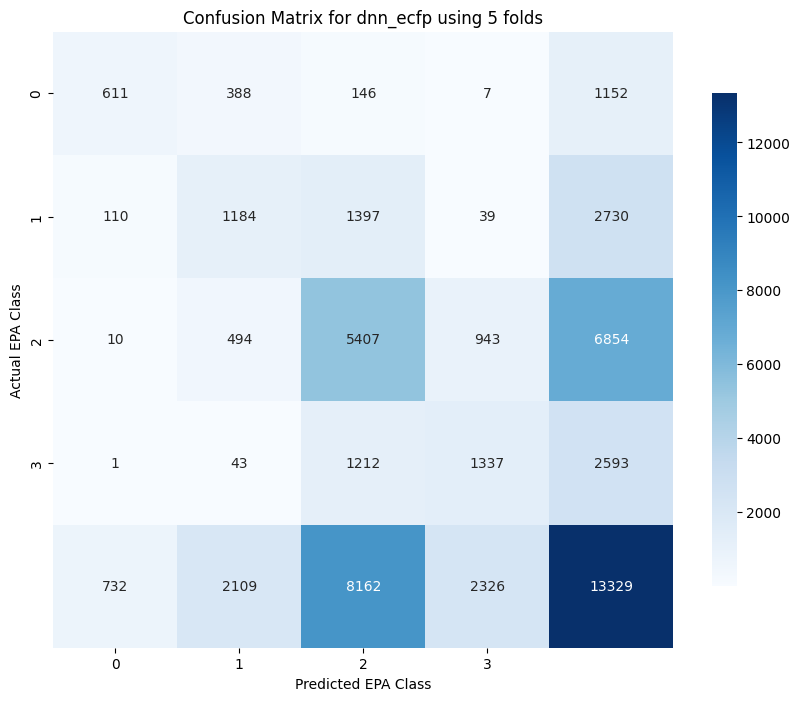

F1 Score of Kfolds = 5 is: 
      Identity  EPA Class  Precision    Recall  F1 Score
0  dnn_mordred          0   0.213144  0.104167  0.139942
1  dnn_mordred          1   0.223917  0.301099  0.256835
2  dnn_mordred          2   0.529245  0.625766  0.573472
3  dnn_mordred          3   0.322906  0.123409  0.178571
4     dnn_ecfp          0   0.834699  0.530382  0.648620
5     dnn_ecfp          1   0.561404  0.433700  0.489357
6     dnn_ecfp          2   0.662460  0.788882  0.720165
7     dnn_ecfp          3   0.574807  0.515619  0.543606


C:\Users\3742\AppData\Local\Temp\ipykernel_11556\1066928843.py:79: FutureWarning: The provided callable <function mean at 0x00000228BD7B6E80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  aggregated_df = aggregated.pivot_table(index='benchmark', aggfunc=np.mean)


In [116]:
#Results Using 5 Folds.
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


output_file = 'ConsolRes.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for identity in compare_benchmarks:
        actual = benchmark_results[identity]['actual']
        predicted = benchmark_results[identity]['predicted']
        
        
        unique_classes = np.sort(np.unique(np.concatenate((actual, predicted))))  # Ensure consistent class order
        cm = confusion_matrix(actual, predicted, labels=unique_classes)

        cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)
        # Add row totals
        cm_df['Row Totals'] = cm_df.sum(axis=1)

        # Add column totals
        cm_df.loc['Column Totals'] = cm_df.sum(axis=0)

        
        # Write the confusion matrix with totals to a specified sheet in the Excel file
        sheet_name = f'{identity}x_train-y-train_Confusion_Matrix'
        cm_df.to_excel(writer, sheet_name=sheet_name)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, cbar_kws={'shrink': 0.8}, 
                    xticklabels=unique_classes, yticklabels=unique_classes)
        #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=unique_classes, yticklabels=unique_classes)
        plt.title(f'Confusion Matrix for {identity} using {fold_no + 1} folds')
        plt.xlabel('Predicted EPA Class')
        plt.ylabel('Actual EPA Class')
        plt.show()


# Placeholder for results
    results = []

    for identity in compare_benchmarks:
        actual = benchmark_results[identity]['actual']
        predicted = benchmark_results[identity]['predicted']
        
        unique_classes = np.sort(np.unique(np.concatenate((actual, predicted))))  # Ensure consistent class order
        cm = confusion_matrix(actual, predicted, labels=unique_classes)
        
        # Calculate precision, recall, and F1 score for each class
        precision = precision_score(actual, predicted, labels=unique_classes, average=None)
        recall = recall_score(actual, predicted, labels=unique_classes, average=None)
        f1 = f1_score(actual, predicted, labels=unique_classes, average=None)
        
        # Add each metric to the results table
        for idx, class_label in enumerate(unique_classes):
            results.append({
                'Identity': identity,
                'EPA Class': class_label,
                'Precision': precision[idx],
                'Recall': recall[idx],
                'F1 Score': f1[idx]
                })

    # Convert results to a DataFrame for easy display
    results_df = pd.DataFrame(results)

    # Display the table
    print(f'F1 Score of Kfolds = {fold_no +1} is: \n{results_df}')

    # Save to Excel if needed
    #output_file = 'F1ScoresOnMatrices_Results.xlsx'
    sheet_name = f'{identity}F1 scores '
    results_df.to_excel(writer, sheet_name = sheet_name) #output_file, index=False)

    sheet_name = f'Ers&Accs{fold_no+1}'
    aggregated_df = aggregated.pivot_table(index='benchmark', aggfunc=np.mean)
    aggregated_df.to_excel(writer, sheet_name = sheet_name)
 


In [ ]:
### Examples of Visualisations 
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

compare_benchmarks = ['dnn_mordred','dnn_ecfp']
aggregated = pd.DataFrame()
#class_orders = [0, 1, 2, 3]


for identity in compare_benchmarks:
    benchmark = _benchmarks[identity]
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, data in folds:
        fn = identity + str(fold_no) + '_' + sampling_type
        validation = pd.read_csv('../../data/benchmark-models/%s_predictions.csv' % fn)

        # Forcing a Int value type
        #validation['actual_epa'] = validation['actual_epa'].astype(int)
        #validation['prediction_epa'] = validation['prediction_epa'].astype(int)
        
        # Ensure that class orders exist in the data to avoid the ValueError
        #actual_classes = set(validation['actual_epa'].unique())
        #predicted_classes = set(validation['prediction_epa'].unique())
        #relevant_classes = [cls for cls in class_orders if cls in actual_classes or cls in predicted_classes]
        
        # Create confusion matrix only for relevant classes present in the data
        #unique_classes = np.unique(validation[['actual_epa', 'prediction_epa']])
        cm = confusion_matrix(validation['actual_epa'], validation['prediction_epa'], labels=unique_classes)
        #cm = confusion_matrix((validation['actual_epa']), (validation['prediction_epa']), labels=relevant_classes)

        #plt.figure(figsize=(8, 6))
        #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {identity}, Fold {fold_no}')
        plt.xlabel('Predicted EPA Class')
        plt.ylabel('Actual EPA Class')
        plt.show()

print(validation['actual_epa'])

''' 
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

compare_benchmarks = ['dnn_mordred', 'dnn_ecfp']
aggregated = pd.DataFrame()
class_orders = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

for identity in compare_benchmarks:
    benchmark = _benchmarks[identity]
    folds = enumerate(kfold.get_folds(benchmark['encoding']))
    
    for fold_no, data in folds:
        fn = identity + str(fold_no) + '_' + sampling_type
        validation = pd.read_csv('../../data/benchmark-models/%s_predictions.csv' % fn)
        
        # Ensure that class orders exist in the data to avoid the ValueError
        actual_classes = set(validation['actual_epa'].unique())
        predicted_classes = set(validation['prediction_epa'].unique())
        relevant_classes = [cls for cls in class_orders if cls in actual_classes or cls in predicted_classes]
        
        # Create confusion matrix only for relevant classes present in the data
        cm = confusion_matrix(validation['actual_epa'], validation['prediction_epa'], labels=relevant_classes)
        
        # Plot the confusion matrix with consistent labels
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=relevant_classes, yticklabels=relevant_classes)
   '''
